In [76]:
#!pip install imutils
import os
import numpy as np
import pandas as pd
import imutils
from imutils import paths
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import img_to_array
from keras.utils import plot_model
from keras.optimizers import SGD

Let's try and break some Captchas! First of all, let's see how our captcha images look like:

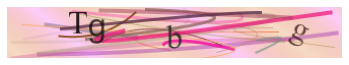

In [5]:
random_image = mpimg.imread("../input/vulnerable-captchas/Captcha Dataset/original/1197516818211787510.png")

fig = plt.figure()
plt.axis("off")
plt.imshow(random_image)
plt.show()

In [2]:
base_path = "../input/vulnerable-captchas/Captcha Dataset/original"
image_paths = list(paths.list_images(base_path))
len(image_paths)

362

A deep learning model would need images with fixed shape to be passed during training. Let's see the size of our images:

In [3]:
digits_base_path = "../input/vulnerable-captchas/Captcha Dataset/labeled"
digit_paths = list(paths.list_images(digits_base_path))
for path in digit_paths[:10]:
    image = cv2.imread(path)
    print(image.shape)

(27, 28, 3)
(27, 22, 3)
(22, 17, 3)
(25, 24, 3)
(23, 19, 3)
(26, 23, 3)
(21, 21, 3)
(21, 20, 3)
(21, 20, 3)
(21, 20, 3)


Just looking at the first 10 images, we can see that they don't have a fixed shape.

In [37]:
def resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w*r), height)
    else:
        r = width / float(w)
        dim = (width, int(h*r))

    resized = cv2.resize(image, dim, interpolation=inter)
    return resized


def preprocess(image, width, height):
    
    (h, w) = image.shape[:2]
    #First of all, resize the image so that the larger
    #dimension matches the desired dimension:
    try:
        if h > w:
            image = resize(image, height=height)
        else:
            image = resize(image, width=width)
    
    #Then, pad the image along the shorter dimension.
    #Number of pads needed in each side of the shorter 
    #dimension:
        padW = (width - image.shape[1]) // 2
        padH = (height - image.shape[0]) // 2
    
    #Apply padding:
        image = cv2.copyMakeBorder(image, padH, padH, padW, padW, cv2.BORDER_REPLICATE)
    
    #Resize again in case the padding needed wasn't
    #an integer:
        image = cv2.resize(image, (width, height))
        return image
    except:
        print("Error, initial dimensions: height:{}, width:{}".format(h,w))
    

In [59]:
#Initialize the preprocessed images' list:
data= []
images = []
labels = []
try:
    for path in digit_paths:
        #for obvious reasons we ommit the unclasiffied
        #images,and since we only have 2 images for I,
        #we exclude them too
        #extract the labels:
        label = path.split(os.path.sep)[-2]
        if label in ["unclassified", "I", "c", "v"]:
            continue
        labels.append(label)
        
        #Preprocess the images:
        digit = cv2.imread(path)
        digit = cv2.cvtColor(digit, cv2.COLOR_BGR2GRAY)
        digit = preprocess(digit, 28, 28)
        
        #append the image so we can visualize it
        #before it gets preprocessed further
        images.append(digit)
        
        #finish preprocessing:
        digit = img_to_array(digit)
    
    
        #Add preprocessed images to the list:
        data.append(digit)
except:   
    print("Error, shape of the image: {}".format(cv2.imread(path).shape))

We have some errors because of some bad images so we just discard them. Let's see an example:

b


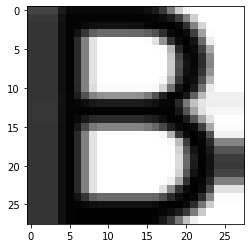

In [45]:
plt.imshow(images[100], cmap="gray")
print(labels[100])

Next, we'll finish preprocessing our data:

In [60]:
data = np.array(data, dtype="float") / 255
labels = np.array(labels)

(X_train, X_test, y_train, y_test) = train_test_split(data, labels, test_size=0.25,
                                                      random_state=42, stratify=labels)
lb = LabelBinarizer().fit(y_train)
y_train = lb.transform(y_train)
y_test = lb.transform(y_test)

Let's define our network:

In [61]:
#LeNet
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras import backend as K

class LeNet:
  @staticmethod
  def build(width, height, depth, classes):
    #initialize the model
    model = Sequential()
    inputShape = (height, width, depth)

    #if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
    #first set of CONV => RELU => POOL layers
    model.add(Conv2D(20, (5,5), padding='same', input_shape=inputShape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    #second set of CONV => RELU => POOL layers
    model.add(Conv2D(50, (5,5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    #set of FCL
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    #softmax classifier
    model.add(Dense(classes, activation='softmax'))
    return model

In [70]:
unique_labels = set(labels)
classes=len(unique_labels)

In [80]:
model = LeNet.build(width=28, height=28, depth=1, classes=classes)
opt = SGD(lr=0.01)
model.compile(loss="categorical_crossentropy", optimizer=opt,
             metrics=["accuracy"])

Let's plot the model to understand it better:

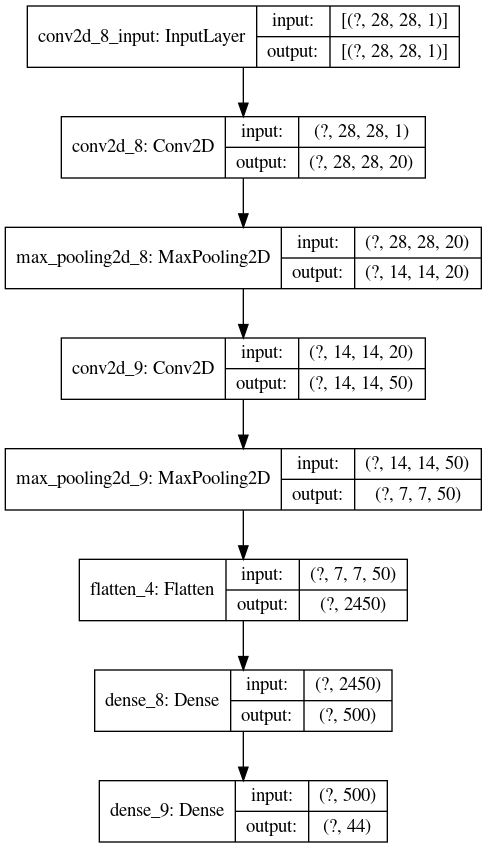

In [78]:
plot_model(model, show_shapes=True)

In [81]:
H = model.fit(X_train, y_train, validation_split = 0.2, batch_size=32,
              epochs=100, verbose=1)

Epoch 1/100
26/26 [==============================] - 1s 50ms/step - loss: 3.7864 - accuracy: 0.0185 - val_loss: 3.7694 - val_accuracy: 0.0343
Epoch 2/100
26/26 [==============================] - 1s 34ms/step - loss: 3.7649 - accuracy: 0.0308 - val_loss: 3.7623 - val_accuracy: 0.0343
Epoch 3/100
26/26 [==============================] - 1s 44ms/step - loss: 3.7491 - accuracy: 0.0382 - val_loss: 3.7528 - val_accuracy: 0.0294
Epoch 4/100
26/26 [==============================] - 1s 33ms/step - loss: 3.7331 - accuracy: 0.0517 - val_loss: 3.7412 - val_accuracy: 0.0392
Epoch 5/100
26/26 [==============================] - 1s 33ms/step - loss: 3.7140 - accuracy: 0.0505 - val_loss: 3.7203 - val_accuracy: 0.0588
Epoch 6/100
26/26 [==============================] - 1s 33ms/step - loss: 3.6895 - accuracy: 0.0998 - val_loss: 3.7132 - val_accuracy: 0.0294
Epoch 7/100
26/26 [==============================] - 1s 33ms/step - loss: 3.6546 - accuracy: 0.0714 - val_loss: 3.6690 - val_accuracy: 0.1225
Epoch 

26/26 [==============================] - 1s 32ms/step - loss: 0.0538 - accuracy: 0.9938 - val_loss: 0.8938 - val_accuracy: 0.8480
Epoch 59/100
26/26 [==============================] - 1s 32ms/step - loss: 0.0550 - accuracy: 0.9938 - val_loss: 0.7514 - val_accuracy: 0.8725
Epoch 60/100
26/26 [==============================] - 1s 31ms/step - loss: 0.0429 - accuracy: 0.9951 - val_loss: 0.7909 - val_accuracy: 0.8775
Epoch 61/100
26/26 [==============================] - 1s 32ms/step - loss: 0.0395 - accuracy: 0.9975 - val_loss: 0.7851 - val_accuracy: 0.8725
Epoch 62/100
26/26 [==============================] - 1s 32ms/step - loss: 0.0402 - accuracy: 0.9951 - val_loss: 0.7949 - val_accuracy: 0.8627
Epoch 63/100
26/26 [==============================] - 1s 32ms/step - loss: 0.0357 - accuracy: 0.9963 - val_loss: 0.7565 - val_accuracy: 0.8824
Epoch 64/100
26/26 [==============================] - 1s 43ms/step - loss: 0.0338 - accuracy: 0.9963 - val_loss: 0.8613 - val_accuracy: 0.8529
Epoch 65/100

In [ ]:
pd.DataFrame(H.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()